 The RAG pipeline will consist of the following three layers:
- Embedding Layer
- Search and Rank Layer
- Generation Layer


The first step in the pipeline is to build the vector store. As illustrated in the image below, this step involves ingesting the documents, processing them to create individual chunks and passing these to an embedding model to create individual vector representations of the text. The second layer in the pipeline is the search and rank layer, which will perform a semantic similarity search on the knowledge bank based on the query and retrieve the top results. The output of this layer is the top K closest documents or chunks for the query and their indices.



The last layer is the generation layer, which receives the results of the previous layer, which contains the top retrieved search results, the original user query and a well-constructed prompt to the LLM. These inputs allow the LLM to generate a more coherent answer that is relevant to the user query with information/relevant chunks stored in the knowledge base.

Overall Design

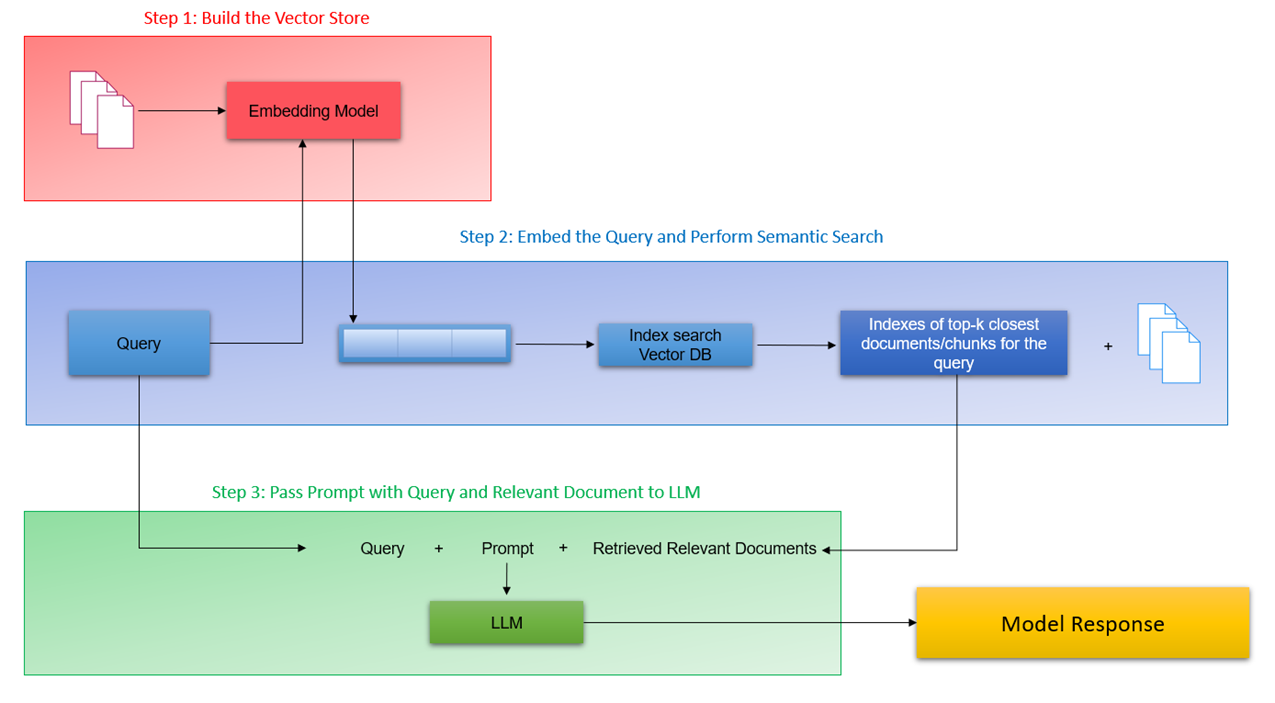

# **1**. **<font color = navy> Install and Import the Required Libraries**


In [ ]:
# mount google drive
from google.colab import drive
drive.mount("/content/drive",force_remount=True)

Mounted at /content/drive


In [ ]:
# Install all the required libraries

!pip install pdfplumber tiktoken openai chromaDB sentence-transformers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 714.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.9/362.9 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.3/584.3 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 50.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 11.4 MB/s eta

In [ ]:
# Import all the required Libraries
import pdfplumber
from pathlib import Path
import pandas as pd
from operator import itemgetter
import json
import openai
import chromadb
from google.colab import userdata

In [ ]:
filepath = "/content/drive/MyDrive/music/Music/gen ai /HELP MATE/"

with open(filepath+"OpenAI_API_Key.txt","r") as f:
  openai.api_key=" ".join(f.readlines())

# **First Step:  Embedding Layer**  

Embedding layer - is not straight forward. First from text corpus to processing documents -- has a lot of pre-processing.

we process the documents (in this case, the documents pertain to the insurance domain) to extract the text, split it into smaller chunks and then pass them to the embedding model.

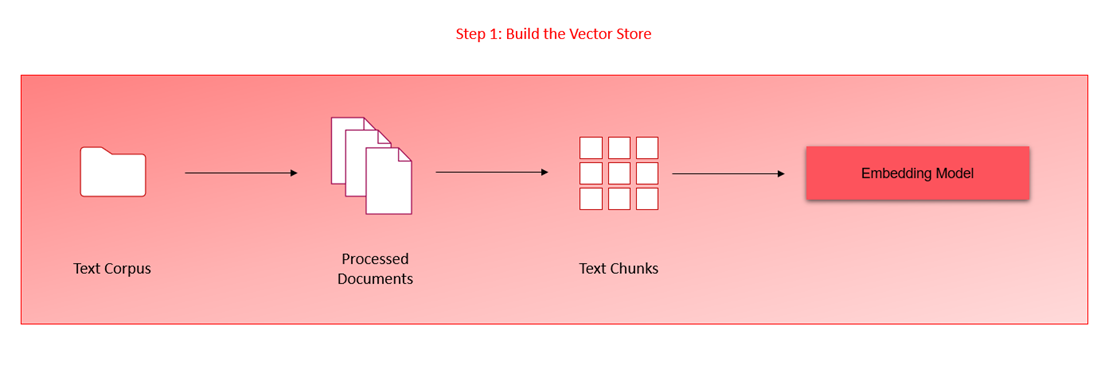

## **2.** **<font color = bROEN> Read, Process, and Chunk the PDF Files**

We will be using [pdfplumber](https://https://pypi.org/project/pdfplumber/) to read and process the PDF files.

`pdfplumber` allows for better parsing of the PDF file as it can read various elements of the PDF apart from the plain text, such as, tables, images, etc. It also offers wide functionaties and visual debugging features to help with advanced preprocessing as well.

In [ ]:
pdf_path="/content/drive/MyDrive/music/Music/gen ai /HELP MATE/"

**Function to check whether a word is present in a table or not for segregation of regular text and tables**



In [ ]:
# Function to check whether a word is present in a table or not for segregation of regular text and tables
def check_bboxes(word,table_bbox):
  l=word["x[0]"],word['top'],word['x1'],word['bottom']
  r=table_bbox
  return l[0]>r[0] and l[1]>r[2] and l[2]<r[2] and l[3]<r[3]

In [ ]:
# Function to extract text from a PDF file.
# 1. Declare a variable p to store the iteration of the loop that will help us store page numbers alongside the text
# 2. Declare an empty list 'full_text' to store all the text files
# 3. Use pdfplumber to open the pdf pages one by one
# 4. Find the tables and their locations in the page
# 5. Extract the text from the tables in the variable 'tables'
# 6. Extract the regular words by calling the function check_bboxes() and checking whether words are present in the table or not
# 7. Use the cluster_objects utility to cluster non-table and table words together so that they retain the same chronology as in the original PDF
# 8. Declare an empty list 'lines' to store the page text
# 9. If a text element in present in the cluster, append it to 'lines', else if a table element is present, append the table
# 10. Append the page number and all lines to full_text, and increment 'p'
# 11. When the function has iterated over all pages, return the 'full_text' list
def extract_text_from_pdf(pdf_path):
    p = 0
    full_text = []


    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            page_no = f"Page {p+1}"
            text = page.extract_text()

            tables = page.find_tables()
            table_bboxes = [i.bbox for i in tables]
            tables = [{'table': i.extract(), 'top': i.bbox[1]} for i in tables]
            non_table_words = [word for word in page.extract_words() if not any(
                [check_bboxes(word, table_bbox) for table_bbox in table_bboxes])]
            lines = []

            for cluster in pdfplumber.utils.cluster_objects(non_table_words + tables, itemgetter('top'), tolerance=5):

                if 'text' in cluster[0]:
                    try:
                        lines.append(' '.join([i['text'] for i in cluster]))
                    except KeyError:
                        pass

                elif 'table' in cluster[0]:
                    lines.append(json.dumps(cluster[0]['table']))


            full_text.append([page_no, " ".join(lines)])
            p +=1

    return full_text


In [ ]:
# Define the directory containing the PDF files
pdf_directory = Path(pdf_path)

# Initialize an empty list to store the extracted texts and document names
data = []

# Loop through all files in the directory
for pdf_path in pdf_directory.glob("*.pdf"):

    # Process the PDF file
    print(f"...Processing {pdf_path.name}")

    # Call the function to extract the text from the PDF
    extracted_text = extract_text_from_pdf(pdf_path)

    # Convert the extracted list to a PDF, and add a column to store document names
    extracted_text_df = pd.DataFrame(extracted_text, columns=['Page No.', 'Page_Text'])
    extracted_text_df['Document Name'] = pdf_path.name

    # Append the extracted text and document name to the list
    data.append(extracted_text_df)

    # Print a message to indicate progress
    print(f"Finished processing {pdf_path.name}")

# Print a message to indicate all PDFs have been processed
print("All PDFs have been processed.")

...Processing Principal-Sample-Life-Insurance-Policy.pdf
Finished processing Principal-Sample-Life-Insurance-Policy.pdf
All PDFs have been processed.


In [ ]:
insurance_pdfs_data = pd.concat(data, ignore_index=True)

In [ ]:
insurance_pdfs_data

,Page No.,Page_Text,Document Name
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,Principal-Sample-Life-Insurance-Policy.pdf
1,Page 2,This page left blank intentionally,Principal-Sample-Life-Insurance-Policy.pdf
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,Principal-Sample-Life-Insurance-Policy.pdf
3,Page 4,This page left blank intentionally,Principal-Sample-Life-Insurance-Policy.pdf
4,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,Principal-Sample-Life-Insurance-Policy.pdf
...,...,...,...
59,Page 60,I f a Dependent who was insured dies during th...,Principal-Sample-Life-Insurance-Policy.pdf
60,Page 61,Section D - Claim Procedures Article 1 - Notic...,Principal-Sample-Life-Insurance-Policy.pdf
61,Page 62,A claimant may request an appeal of a claim de...,Principal-Sample-Life-Insurance-Policy.pdf
62,Page 63,This page left blank intentionally,Principal-Sample-Life-Insurance-Policy.pdf


In [ ]:
insurance_pdfs_data['Text_Length']=insurance_pdfs_data['Page_Text'].apply(lambda x:len(x.split(" ")))

In [ ]:
insurance_pdfs_data.head(3)

,Page No.,Page_Text,Document Name,Text_Length
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,Principal-Sample-Life-Insurance-Policy.pdf,30
1,Page 2,This page left blank intentionally,Principal-Sample-Life-Insurance-Policy.pdf,5
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,Principal-Sample-Life-Insurance-Policy.pdf,230


In [ ]:
max(insurance_pdfs_data['Text_Length'])

462



*  To ignore the blank pages with minimum of 10 words, we use the following code to ignore the blank page -- which has minimun of 10 words or only has header or footer




In [ ]:
# Retain only the rows with a text length of at least 10
insurance_pdfs_data = insurance_pdfs_data.loc[insurance_pdfs_data['Text_Length'] >= 10]
insurance_pdfs_data.head(3)

,Page No.,Page_Text,Document Name,Text_Length
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,Principal-Sample-Life-Insurance-Policy.pdf,30
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,Principal-Sample-Life-Insurance-Policy.pdf,230
4,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,Principal-Sample-Life-Insurance-Policy.pdf,110


In [ ]:
  # Store the metadata for each page in a separate column
  insurance_pdfs_data['MetaData']=insurance_pdfs_data.apply(lambda x:{"Policy_Name":x["Document Name"][:-4],"Page_No":x['Page No.']}, axis=1)

<ipython-input-15-17f4291bb3ef>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  insurance_pdfs_data['MetaData']=insurance_pdfs_data.apply(lambda x:{"Policy_Name":x["Document Name"][:-4],"Page_No":x['Page No.']}, axis=1)


In [ ]:
insurance_pdfs_data.head()

,Page No.,Page_Text,Document Name,Text_Length,MetaData
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,Principal-Sample-Life-Insurance-Policy.pdf,30,{'Policy_Name': 'Principal-Sample-Life-Insuran...
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,Principal-Sample-Life-Insurance-Policy.pdf,230,{'Policy_Name': 'Principal-Sample-Life-Insuran...
4,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,Principal-Sample-Life-Insurance-Policy.pdf,110,{'Policy_Name': 'Principal-Sample-Life-Insuran...
5,Page 6,TABLE OF CONTENTS PART I - DEFINITIONS PART II...,Principal-Sample-Life-Insurance-Policy.pdf,153,{'Policy_Name': 'Principal-Sample-Life-Insuran...
6,Page 7,Section A – Eligibility Member Life Insurance ...,Principal-Sample-Life-Insurance-Policy.pdf,176,{'Policy_Name': 'Principal-Sample-Life-Insuran...


This concludes the chunking aspect also, as we can see that mostly the pages contain few hundred words, maximum going upto 1000. So, we don't need to chunk the documents further; we can perform the embeddings on individual pages. This strategy makes sense for 2 reasons:
1. The way insurance documents are generally structured, you will not have a lot of extraneous information in a page, and all the text pieces in that page will likely be interrelated.
2. We want to have larger chunk sizes to be able to pass appropriate context to the LLM during the generation layer.

# **3. <font color = navy> Generate and Store Embeddings using OpenAI and ChromaDB**
*   In this section, we will embed the pages in the dataframe through OpenAI's `text-embedding-ada-002` model, and store them in a ChromaDB collection





In [ ]:
# Import the OpenAI Embedding Function into chroma
from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction

In [ ]:
# Define the path where chroma collections will be stored
chroma_data_path="/content/drive/MyDrive/music/Music/gen ai /HELP MATE/Chromadb_pathF"

In [ ]:
# Call PersistentClient()
client=chromadb.PersistentClient(path=chroma_data_path)

In [ ]:
# Set up the embedding function using the OpenAI embedding model
model='text-embedding-ada-002'
embedding_function=OpenAIEmbeddingFunction(api_key=openai.api_key,model_name=model)

In [ ]:
from chromadb.utils import embedding_functions
sentence_transformer_ef=embedding_functions.SentenceTransformerEmbeddingFunction(model_name="all-MiniLM-L6-v2")

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# Convert the page text and metadata from your dataframe to lists to be able to pass it to chroma
document_list=insurance_pdfs_data['Page_Text'].to_list()
metadata_list=insurance_pdfs_data['MetaData'].to_list()

In [ ]:
# Initialise a collection in chroma and pass the embedding_function to it so that it used OpenAI embeddings to embed the documents
insurance_collection=client.get_or_create_collection(name="Rag_on_insurance",embedding_function=sentence_transformer_ef)

In [ ]:
# Add the documents and metadata to the collection alongwith generic integer IDs. You can also feed the metadata information as IDs by combining the policy name and page no.
insurance_collection.add(documents=document_list,metadatas=metadata_list,ids=[str(i) for i in range(0,len(document_list))])

In [ ]:
# Let's take a look at the first few entries in the collection

insurance_collection.get(
    ids = ['0','1','2'],
    include = ['embeddings', 'documents', 'metadatas']
)

{'ids': ['0', '1', '2'],
 'embeddings': [[-0.0259218979626894,
   0.047777511179447174,
   0.05585773289203644,
   0.042397454380989075,
   0.058143001049757004,
   0.10849818587303162,
   0.028891010209918022,
   -0.009777740575373173,
   -0.08766453713178635,
   0.02725154347717762,
   0.0377378948032856,
   0.04159489646553993,
   -0.013698939234018326,
   -0.060469530522823334,
   -0.09530660510063171,
   -0.0355200469493866,
   -0.05023420974612236,
   0.01387762650847435,
   -0.038272373378276825,
   0.03651922196149826,
   0.009495577774941921,
   0.03799034282565117,
   -0.06191487982869148,
   -0.033394716680049896,
   0.03203490003943443,
   0.00034457945730537176,
   0.034971076995134354,
   -0.048203859478235245,
   0.021832682192325592,
   0.00023781575146131217,
   0.004617196973413229,
   -0.036271125078201294,
   -0.03494362160563469,
   0.04148419573903084,
   0.03391353040933609,
   -0.008206160739064217,
   -0.04822535440325737,
   -0.0033177833538502455,
   -0.02519

In [ ]:
cache_collection = client.get_or_create_collection(name='Insurance_Cache', embedding_function=embedding_function)

In [ ]:
cache_collection.peek()

{'ids': [" 'What happens if a third-party service provider fails to provide the promised goods and services?' ",
  'What are the default benefits and provisions of the Group Policy?',
  'what are the advantages of this group policy?'],
 'embeddings': [[0.012977585196495056,
   -0.009317073971033096,
   -0.002698245458304882,
   -0.00685939472168684,
   0.004271680023521185,
   0.018790191039443016,
   0.004957619588822126,
   -0.0030655968002974987,
   -4.2236275476170704e-05,
   -0.015123177319765091,
   0.004375708755105734,
   0.02361452393233776,
   0.010578421875834465,
   -0.02300335466861725,
   0.020285602658987045,
   0.002522696740925312,
   0.021650981158018112,
   0.005773595068603754,
   0.006956921890377998,
   -0.033081136643886566,
   -0.002872168319299817,
   -0.005682569928467274,
   -0.027749665081501007,
   0.0048308344557881355,
   0.008055725134909153,
   0.002249621320515871,
   0.021781016141176224,
   -0.029726210981607437,
   0.004222916439175606,
   0.0395569

once the text in the documents has been pre-processed and chunked, the next step is to generate vector representations using a suitable text embedding model. So far, you have been using the sentence transformer library and, specifically, the all-MiniLM-L6-V2 model to generate vector embeddings. For this demonstration, the embedding model being used is OpenAI's embedding model - specifically, the ada002 v2 model, which embeds text into a vector of 1,536 dimensions. We are using ChromaDB’s utilities functions to generate the vector embeddings through OpenAI’s model.


Once the embeddings have been generated, the next step is to store them in the vector database, which is ChromaDB. As covered in the previous sessions on ChromaDB, you need to first create the Chroma collections before you can start adding documents. Akshay used the get_or_create_collections method, which will create a collection if not already present, and fetch it from your system if it has been created and stored previously. Next, since we are using OpenAI embeddings and not Chroma's default embedding, you need to also pass your embedding function as an argument while creating the collection. Finally, the information that includes the document list, text and metadata information is passed to the chroma collection. Additionally, Akshay also created a Chroma collection to serve as cache, which we will explore in the upcoming segment.

As with any good system design, we need to consider a scenario when the application is scaled - suppose the number of documents increases or multiple users are using the application. Such a scenario opens up multiple concerns about the system’s performance

- How will the system handle multiple queries simultaneously?
- Is there scope to improve the system’s overall performance in search and retrieval?



The first concern can be solved by using vector databases and scaling up the compute units (clusters/server) for the application. For the second concern, an improvement to the overall system design is required which can be achieved by implementing a cache collection in the vector database that stores previous queries and their results in the vector database. Let’s hear more on this from Akshay in the video below.

System Design of Semantic Search Layer:

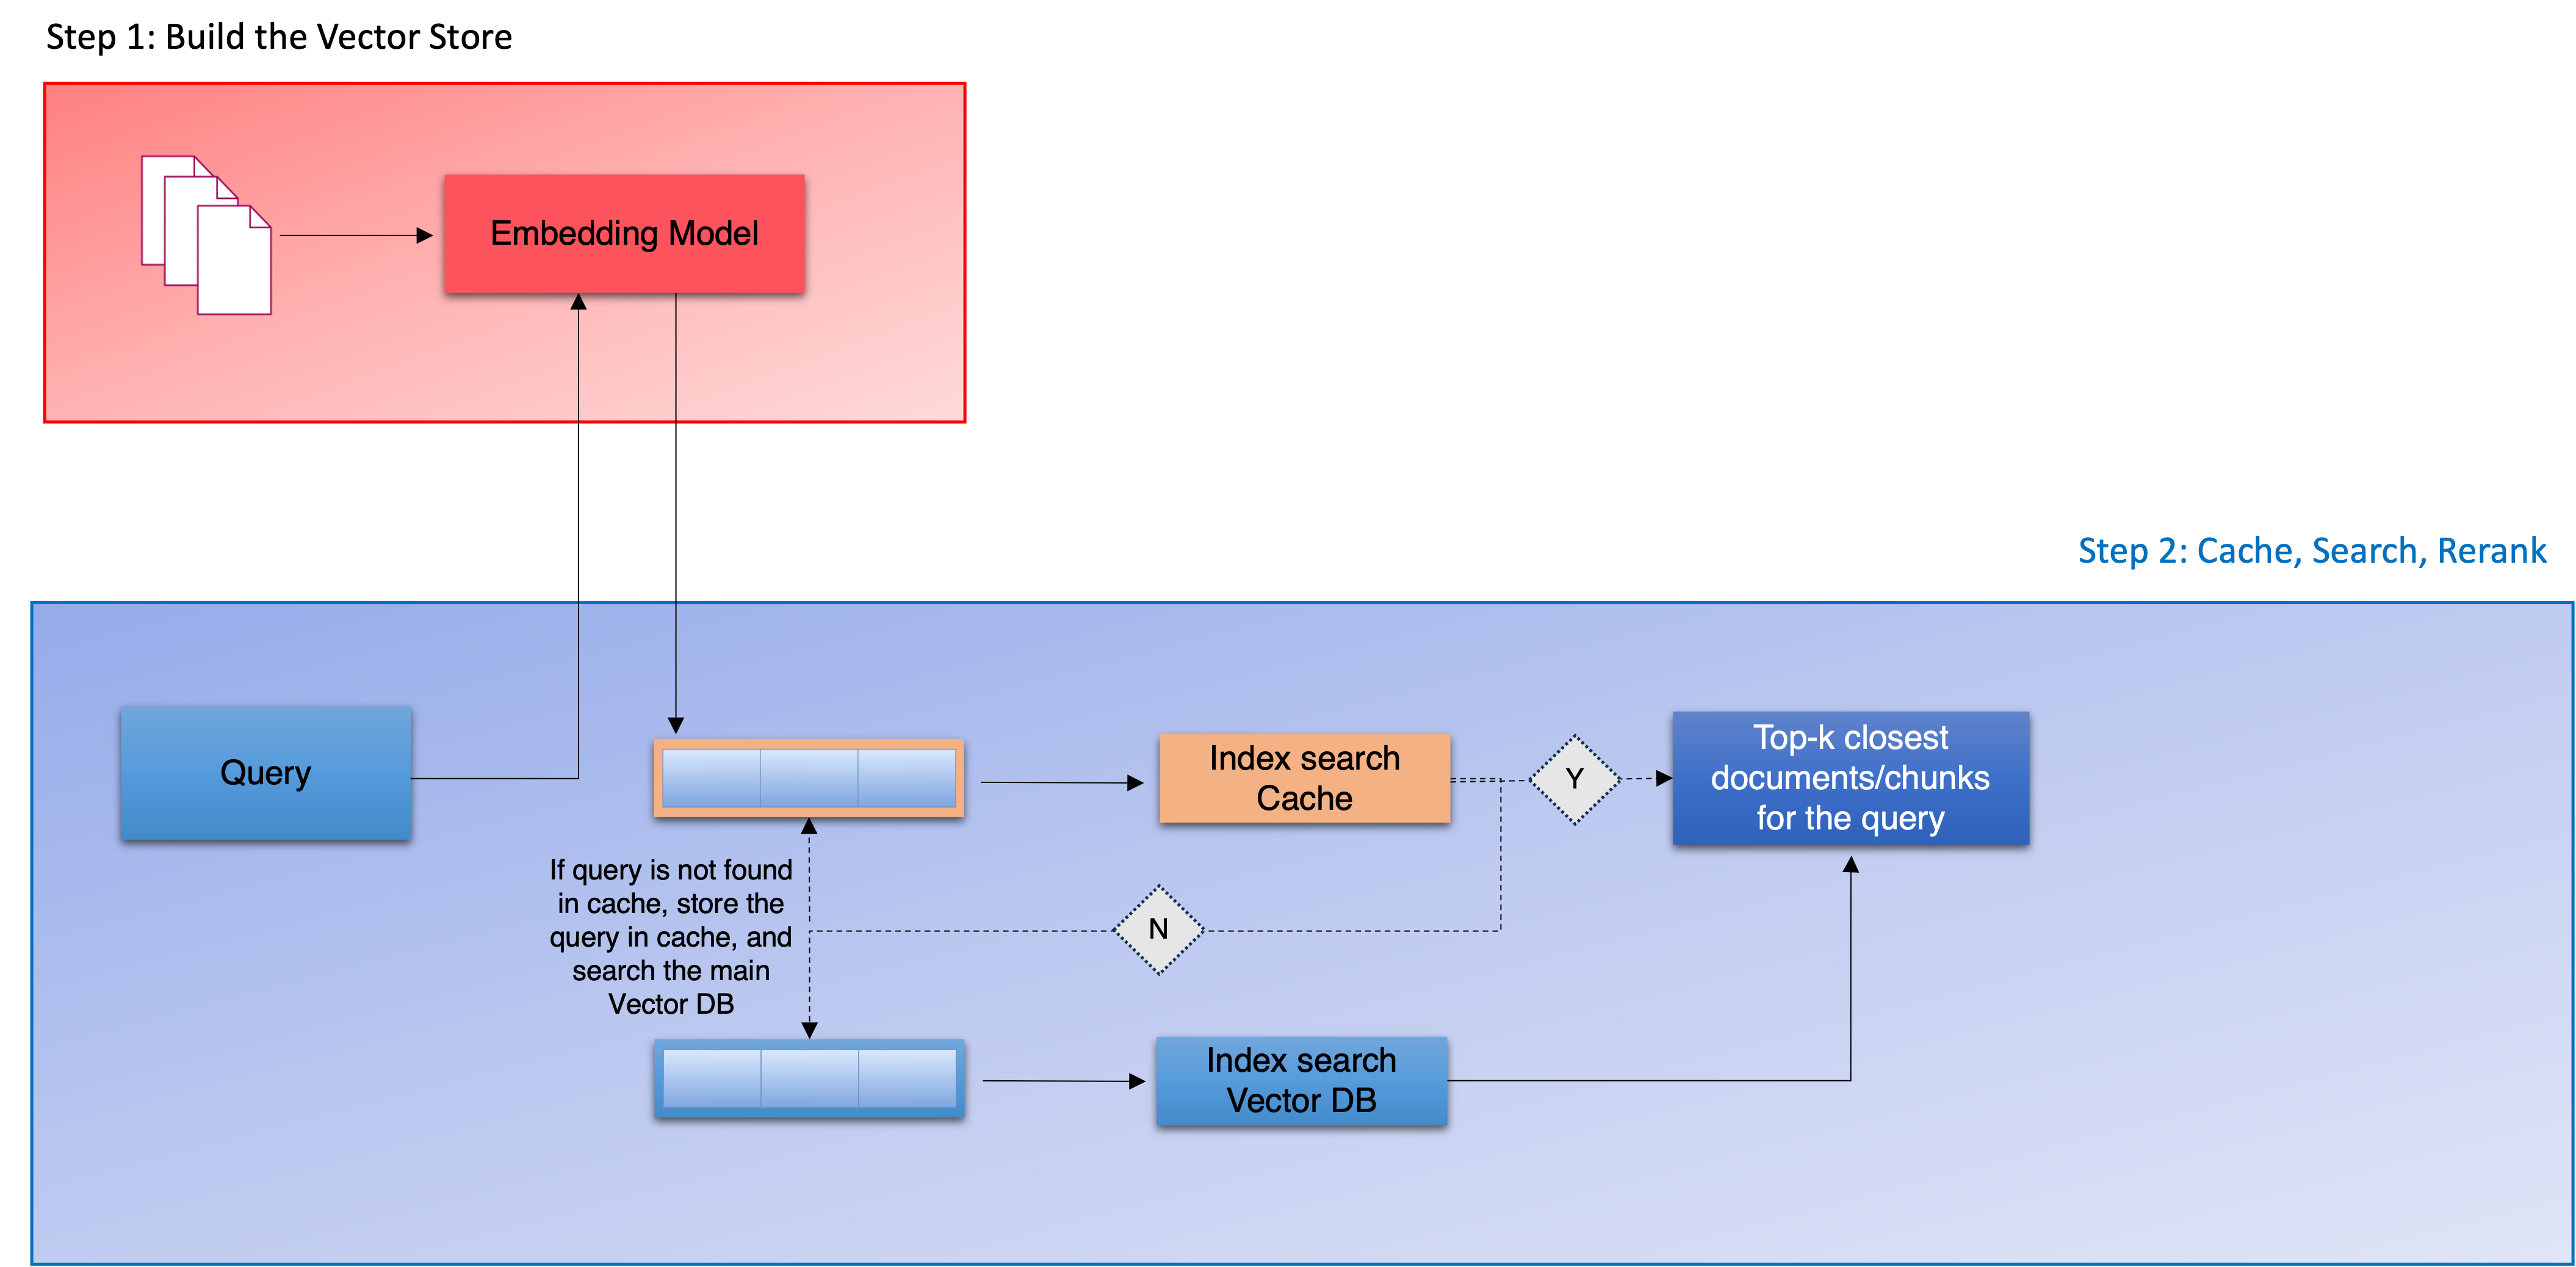

# **4. <font color = briwn> Semantic Search with Cache**

In this section, we will perform a semantic search of a query in the collections embeddings to get several top semantically similar results.

## When designing a cache layer in a semantic search system, the following considerations should be addressed:

### Document Query Flow:

#### Initial Search in Cache:

- **Query Lookup:** When a document query is received, the system first checks the cache for any stored results that match or are similar to the current query.
- **Cache Hit:** If the query is found in the cache, the system retrieves and returns the top `k` closest documents or chunks of documents from the cache.

#### Fallback to Main Vector Database:

- **Cache Miss:** If the query is not found in the cache, the system proceeds to search the main vector database.
- **Query Execution:** The system performs the semantic search on the main vector database to find and retrieve the top `k` closest documents or chunks of documents.
- **Cache Storage:** The system stores the query and its corresponding results in the cache for future use. This step ensures that if a similar query is made in the future, the system can quickly return the cached results, improving efficiency.

#### Result Return:

- The system returns the top `k` closest documents or chunks of documents as the final result, either from the cache (in the case of a cache hit) or from the main vector database (in the case of a cache miss).


In [ ]:
# Read the user query

query = input()

What will be premium rate(s) for each Member insured for Life Insurance ?


In [ ]:
# Searh the Cache collection first
# Query the collection against the user query and return the top 20 results

In [ ]:
cache_results=cache_collection.query(query_texts=query,n_results=1)

In [ ]:
cache_results

{'ids': [['What are the default benefits and provisions of the Group Policy?']],
 'distances': [[0.4237089603167183]],
 'metadatas': [[{'distances0': '0.8645804092683532',
    'distances1': '0.884373626261494',
    'distances2': '0.9797315370885183',
    'distances3': '1.0185734995764695',
    'distances4': '1.0266767881873475',
    'distances5': '1.0518577253121755',
    'distances6': '1.061697133335048',
    'distances7': '1.1031167355558353',
    'distances8': '1.1138282936578878',
    'distances9': '1.1176433858899277',
    'documents0': "PART II - POLICY ADMINISTRATION Section A - Contract Article 1 - Entire Contract This Group Policy, the current Certificate, the attached Policyholder application, and any Member applications make up the entire contract. The Principal is obligated only as provided in this Group Policy and is not bound by any trust or plan to which it is not a signatory party. Article 2 - Policy Changes Insurance under this Group Policy runs annually to the Policy 

In [ ]:
results=insurance_collection.query(query_texts=query,n_results=5)


In [ ]:
results.items()

dict_items([('ids', [['17', '39', '49', '19', '18']]), ('distances', [[0.7461310625076294, 0.7545526623725891, 0.8269239664077759, 0.8312831521034241, 0.8446989059448242]]), ('metadatas', [[{'Page_No': 'Page 20', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy'}, {'Page_No': 'Page 42', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy'}, {'Page_No': 'Page 52', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy'}, {'Page_No': 'Page 22', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy'}, {'Page_No': 'Page 21', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy'}]]), ('embeddings', None), ('documents', [['Section B - Premiums Article 1 - Payment Responsibility; Due Dates; Grace Period The Policyholder is responsible for collection and payment of all premiums due while this Group Policy is in force. Payments must be sent to the home office of The Principal in Des Moines, Iowa. The first premium is due on the Date of Issue of this Group Policy. Each premium therea

In [ ]:
# Implementing Cache in Semantic Search

# Set a threshold for cache search
threshold=0.2
ids = []
documents = []
distances = []
metadatas = []
results_df = pd.DataFrame()
# If the distance is greater than the threshold, then return the results from the main collection.
# If the distance is greater than the threshold, then return the results from the main collection.

if cache_results['distances'][0] == [] or cache_results['distances'][0][0] > threshold:
      # Query the collection against the user query and return the top 10 results
      results = insurance_collection.query(
      query_texts=query,
      n_results=10
      )

      # Store the query in cache_collection as document w.r.t to ChromaDB so that it can be embedded and searched against later
      # Store retrieved text, ids, distances and metadatas in cache_collection as metadatas, so that they can be fetched easily if a query indeed matches to a query in cache
      Keys = []
      Values = []

      for key, val in results.items():
        if val is None:
          continue
        if key != 'embeddings':
          for i in range(len(val[0])):
             Keys.append(str(key)+str(i))
             Values.append(str(val[0][i]))


      cache_collection.add(
          documents= [query],
          ids = [query],  # Or if you want to assign integers as IDs 0,1,2,.., then you can use "len(cache_results['documents'])" as will return the no. of queries currently in the cache and assign the next digit to the new query."
          metadatas = dict(zip(Keys, Values))
      )

      print("Not found in cache. Found in main collection.")

      result_dict = {'Metadatas': results['metadatas'][0], 'Documents': results['documents'][0], 'Distances': results['distances'][0], "IDs":results["ids"][0]}
      results_df = pd.DataFrame.from_dict(result_dict)
      results_df


# If the distance is, however, less than the threshold, you can return the results from cache

elif cache_results['distances'][0][0] <= threshold:
      cache_result_dict = cache_results['metadatas'][0][0]

      # Loop through each inner list and then through the dictionary
      for key, value in cache_result_dict.items():
          if 'ids' in key:
              ids.append(value)
          elif 'documents' in key:
              documents.append(value)
          elif 'distances' in key:
              distances.append(value)
          elif 'metadatas' in key:
              metadatas.append(value)

      print("Found in cache!")

      # Create a DataFrame
      results_df = pd.DataFrame({
        'IDs': ids,
        'Documents': documents,
        'Distances': distances,
        'Metadatas': metadatas
      })



Not found in cache. Found in main collection.


In [ ]:
  results_df

,Metadatas,Documents,Distances,IDs
0,"{'Page_No': 'Page 20', 'Policy_Name': 'Princip...",Section B - Premiums Article 1 - Payment Respo...,0.746131,17
1,"{'Page_No': 'Page 42', 'Policy_Name': 'Princip...",Section F - Individual Purchase Rights Article...,0.754553,39
2,"{'Page_No': 'Page 52', 'Policy_Name': 'Princip...",(1) only one Accelerated Benefit payment will ...,0.826924,49
3,"{'Page_No': 'Page 22', 'Policy_Name': 'Princip...",The number of Members insured for Dependent Li...,0.831283,19
4,"{'Page_No': 'Page 21', 'Policy_Name': 'Princip...",b . on any date the definition of Member or De...,0.844699,18
5,"{'Page_No': 'Page 46', 'Policy_Name': 'Princip...",PART IV - BENEFITS Section A - Member Life Ins...,0.888411,43
6,"{'Page_No': 'Page 8', 'Policy_Name': 'Principa...",Section A - Member Life Insurance Schedule of ...,0.936101,5
7,"{'Page_No': 'Page 44', 'Policy_Name': 'Princip...",(4) Premium will be based on the Dependent's a...,0.981913,41
8,"{'Page_No': 'Page 5', 'Policy_Name': 'Principa...",PRINCIPAL LIFE INSURANCE COMPANY (called The P...,0.999664,2
9,"{'Page_No': 'Page 35', 'Policy_Name': 'Princip...",Section C - Individual Terminations Article 1 ...,1.016849,32


In [ ]:
query2 = input()

What are the Termination Rights of the Policyholder?


In [ ]:
# Searh the Cache collection first
cache_results2=cache_collection.query(query_texts=query,n_results=1)

In [ ]:
cache_results2

{'ids': [['What will be premium rate(s) for each Member insured for Life Insurance ?']],
 'distances': [[0.0]],
 'metadatas': [[{'distances0': '0.7461310625076294',
    'distances1': '0.7545526623725891',
    'distances2': '0.8269239664077759',
    'distances3': '0.8312831521034241',
    'distances4': '0.8446989059448242',
    'distances5': '0.8884111642837524',
    'distances6': '0.9361005425453186',
    'distances7': '0.9819127917289734',
    'distances8': '0.9996638298034668',
    'distances9': '1.0168488025665283',
    'documents0': 'Section B - Premiums Article 1 - Payment Responsibility; Due Dates; Grace Period The Policyholder is responsible for collection and payment of all premiums due while this Group Policy is in force. Payments must be sent to the home office of The Principal in Des Moines, Iowa. The first premium is due on the Date of Issue of this Group Policy. Each premium thereafter will be due on the first of each Insurance Month. Except for the first premium, a Grace 

In [ ]:
# Implementing Cache in Semantic Search

# Set a threshold for cache search
threshold = 0.2

ids2 = []
documents2 = []
distances2 = []
metadatas2 = []
results_df2 = pd.DataFrame()


# If the distance is greater than the threshold, then return the results from the main collection.

if cache_results2['distances'][0] == [] or cache_results2['distances'][0][0] > threshold:
      # Query the collection against the user query and return the top 10 results
      results = insurance_collection.query(
      query_texts=query2,
      n_results=10
      )

      # Store the query in cache_collection as document w.r.t to ChromaDB so that it can be embedded and searched against later
      # Store retrieved text, ids, distances and metadatas in cache_collection as metadatas, so that they can be fetched easily if a query indeed matches to a query in cache
      Keys2 = []
      Values2 = []

      for key, val in results.items():
        if val is None:
          continue
        if key != 'embeddings':
          for i in range(10): # Top 10 variable, we can also put as 25 for top_n
            Keys2.append(str(key)+str(i))
            Values2.append(str(val[0][i]))


      cache_collection.add(
          documents= [query2],
          ids = [query2],  # Or if you want to assign integers as IDs 0,1,2,.., then you can use "len(cache_results['documents'])" as will return the no. of queries currently in the cache and assign the next digit to the new query."
          metadatas = dict(zip(Keys2, Values2))
      )

      print("Not found in cache. Found in main collection.")

      result_dict2 = {'Metadatas': results['metadatas'][0], 'Documents': results['documents'][0], 'Distances': results['distances'][0], "IDs":results["ids"][0]}
      results_df2 = pd.DataFrame.from_dict(result_dict2)
      results_df2


# If the distance is, however, less than the threshold, you can return the results from cache

elif cache_results2['distances'][0][0] <= threshold:
      cache_result_dict2 = cache_results2['metadatas'][0][0]

      # Loop through each inner list and then through the dictionary
      for key, value in cache_result_dict2.items():
          if 'ids' in key:
              ids2.append(value)
          elif 'documents' in key:
              documents2.append(value)
          elif 'distances' in key:
              distances2.append(value)
          elif 'metadatas' in key:
              metadatas2.append(value)

      print("Found in cache!")

      # Create a DataFrame
      results_df2 = pd.DataFrame({
        'IDs': ids2,
        'Documents': documents2,
        'Distances': distances2,
        'Metadatas': metadatas2
      })


Found in cache!


In [ ]:
results_df2

,IDs,Documents,Distances,Metadatas
0,17,Section B - Premiums Article 1 - Payment Respo...,0.7461310625076294,"{'Page_No': 'Page 20', 'Policy_Name': 'Princip..."
1,39,Section F - Individual Purchase Rights Article...,0.7545526623725891,"{'Page_No': 'Page 42', 'Policy_Name': 'Princip..."
2,49,(1) only one Accelerated Benefit payment will ...,0.8269239664077759,"{'Page_No': 'Page 52', 'Policy_Name': 'Princip..."
3,19,The number of Members insured for Dependent Li...,0.8312831521034241,"{'Page_No': 'Page 22', 'Policy_Name': 'Princip..."
4,18,b . on any date the definition of Member or De...,0.8446989059448242,"{'Page_No': 'Page 21', 'Policy_Name': 'Princip..."
5,43,PART IV - BENEFITS Section A - Member Life Ins...,0.8884111642837524,"{'Page_No': 'Page 46', 'Policy_Name': 'Princip..."
6,5,Section A - Member Life Insurance Schedule of ...,0.9361005425453186,"{'Page_No': 'Page 8', 'Policy_Name': 'Principa..."
7,41,(4) Premium will be based on the Dependent's a...,0.9819127917289734,"{'Page_No': 'Page 44', 'Policy_Name': 'Princip..."
8,2,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,0.9996638298034668,"{'Page_No': 'Page 5', 'Policy_Name': 'Principa..."
9,32,Section C - Individual Terminations Article 1 ...,1.0168488025665283,"{'Page_No': 'Page 35', 'Policy_Name': 'Princip..."


In [ ]:
# Read the user query

query3 = input()

'What happens if a third-party service provider fails to provide the promised goods and services?'


In [ ]:
cache_results3 = cache_collection.query(
    query_texts=query3,
    n_results=1
)

In [ ]:
cache_results3

{'ids': [[" 'What happens if a third-party service provider fails to provide the promised goods and services?' "]],
 'distances': [[0.04433237553866745]],
 'metadatas': [[{'distances0': '1.034203557749381',
    'distances1': '1.3209689481093276',
    'distances2': '1.3299269818227348',
    'distances3': '1.3368163417480385',
    'distances4': '1.3578642391982536',
    'distances5': '1.3908556844381628',
    'distances6': '1.404544698071014',
    'distances7': '1.4272020791093507',
    'distances8': '1.4406421138163497',
    'distances9': '1.4587884915049147',
    'documents0': 'POLICY RIDER GROUP INSURANCE POLICY NO: S655 COVERAGE: Life EMPLOYER: RHODE ISLAND JOHN DOE Effective on the later of the Date of Issue of this Group Policy or March 1, 2005, the following will apply to your Policy: From time to time The Principal may offer or provide certain employer groups who apply for coverage with The Principal a Financial Services Hotline and Grief Support Services or any other value added

In [ ]:
# Implementing Cache in Semantic Search

# Set a threshold for cache search
threshold = 0.2

ids3 = []
documents3 = []
distances3 = []
metadatas3 = []
results_df3 = pd.DataFrame()


# If the distance is greater than the threshold, then return the results from the main collection.

if cache_results3['distances'][0] == [] or cache_results3['distances'][0][0] > threshold:
      # Query the collection against the user query and return the top 10 results
      results = insurance_collection.query(
      query_texts=query3,
      n_results=10
      )

      # Store the query in cache_collection as document w.r.t to ChromaDB so that it can be embedded and searched against later
      # Store retrieved text, ids, distances and metadatas in cache_collection as metadatas, so that they can be fetched easily if a query indeed matches to a query in cache
      Keys3 = []
      Values3 = []

      for key, val in results.items():
        if val is None:
          continue
        if key != 'embeddings':
          for i in range(10): # Top 10 variable, we can also put as 25 for top_n
             if i< len(val[0]):
                Keys3.append(str(key)+str(i))
                Values3.append(str(val[0][i]))


      cache_collection.add(
          documents= [query3],
          ids = [query3],  # Or if you want to assign integers as IDs 0,1,2,.., then you can use "len(cache_results['documents'])" as will return the no. of queries currently in the cache and assign the next digit to the new query."
          metadatas = dict(zip(Keys3, Values3))
      )

      print("Not found in cache. Found in main collection.")

      result_dict3 = {'Metadatas': results['metadatas'][0], 'Documents': results['documents'][0], 'Distances': results['distances'][0], "IDs":results["ids"][0]}
      results_df3 = pd.DataFrame.from_dict(result_dict3)
      results_df3


# If the distance is, however, less than the threshold, you can return the results from cache

elif cache_results3['distances'][0][0] <= threshold:
      cache_result_dict3 = cache_results3['metadatas'][0][0]

      # Loop through each inner list and then through the dictionary
      for key, value in cache_result_dict3.items():
          if 'ids' in key:
              ids3.append(value)
          elif 'documents' in key:
              documents3.append(value)
          elif 'distances' in key:
              distances3.append(value)
          elif 'metadatas' in key:
              metadatas3.append(value)

      print("Found in cache!")

      # Create a DataFrame
      results_df3 = pd.DataFrame({
        'IDs': ids3,
        'Documents': documents3,
        'Distances': distances3,
        'Metadatas': metadatas3
      })


Found in cache!


In [ ]:
results_df3

,IDs,Documents,Distances,Metadatas
0,1,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,1.034203557749381,"{'Page_No': 'Page 3', 'Policy_Name': 'Principa..."
1,21,T he Principal may terminate the Policyholder'...,1.3209689481093276,"{'Page_No': 'Page 24', 'Policy_Name': 'Princip..."
2,16,T he Principal has complete discretion to cons...,1.3299269818227348,"{'Page_No': 'Page 19', 'Policy_Name': 'Princip..."
3,20,Section C - Policy Termination Article 1 - Fai...,1.3368163417480385,"{'Page_No': 'Page 23', 'Policy_Name': 'Princip..."
4,15,c . a copy of the form which contains the stat...,1.3578642391982536,"{'Page_No': 'Page 18', 'Policy_Name': 'Princip..."
5,3,TABLE OF CONTENTS PART I - DEFINITIONS PART II...,1.3908556844381628,"{'Page_No': 'Page 6', 'Policy_Name': 'Principa..."
6,44,"M ember's death, the Death Benefits Payable ma...",1.404544698071014,"{'Page_No': 'Page 47', 'Policy_Name': 'Princip..."
7,14,a. be actively engaged in business for profit ...,1.4272020791093507,"{'Page_No': 'Page 17', 'Policy_Name': 'Princip..."
8,33,A Member's insurance under this Group Policy f...,1.4406421138163497,"{'Page_No': 'Page 36', 'Policy_Name': 'Princip..."
9,58,Section D - Claim Procedures Article 1 - Notic...,1.4587884915049147,"{'Page_No': 'Page 61', 'Policy_Name': 'Princip..."



A semantic cache stores the meaning of a query or request, rather than just the raw data and responses. This approach reduces the load on the database by recalling previous queries and their results, effectively bypassing the semantic search layer, which is often a system bottleneck.

Here’s how it works: when a query is received, its vector representation is generated and first checked against the cache. If the query is found in the cache, the system can immediately provide the cached response without further processing. If the query is not found, the system queries the main collection to retrieve the top k closest documents or chunks relevant to the query. The results are then returned to the user and simultaneously stored in the cache along with the query.

By storing previous queries and their results, the cache enables faster response times, leading to improved application performance. Moreover, customizing and monitoring the cache's performance can further enhance its efficiency, ensuring that users experience quicker and more reliable interactions.

# **5. <font color = navy> Re-Ranking with a Cross Encoder**

Re-ranking the results obtained from your semantic search can sometime significantly improve the relevance of the retrieved results. This is often done by passing the query paired with each of the retrieved responses into a cross-encoder to score the relevance of the response w.r.t. the query.

<br>

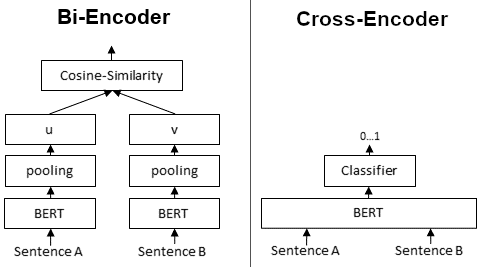

<br>

The **re-ranking stage** is a crucial next step in building a robust semantic search pipeline. In our current semantic search application, the system returns the top **K** documents that appear to be relevant to the user's query. However, the quality and accuracy of the information in these documents can vary. At times, the system may retrieve documents that are not entirely aligned with the search query.

The **re-ranking layer** addresses this by carefully examining these top **K** results to verify their relevance and accuracy in relation to the query. It then ranks them or assigns an importance score to each result, ensuring that the most relevant and accurate information is prioritized.

### Benefits of Re-Ranking in Generative Search

- **Enhanced accuracy and relevance** of the generated results
- **Minimized presentation of irrelevant or inaccurate information** to the user
- **More personalized and informative search results**
- **Ability to tailor search results** to specific tasks or domains

Traditionally, various re-ranking methods have been used in search, including **Reciprocal Rank Fusion (RRF)**, hybrid search methods, and **cross-encoder models**. For this project, we will focus on the widely-used **cross-encoders** method for our re-ranking task.


In [ ]:
results_df.head()

,Metadatas,Documents,Distances,IDs
0,"{'Page_No': 'Page 20', 'Policy_Name': 'Princip...",Section B - Premiums Article 1 - Payment Respo...,0.746131,17
1,"{'Page_No': 'Page 42', 'Policy_Name': 'Princip...",Section F - Individual Purchase Rights Article...,0.754553,39
2,"{'Page_No': 'Page 52', 'Policy_Name': 'Princip...",(1) only one Accelerated Benefit payment will ...,0.826924,49
3,"{'Page_No': 'Page 22', 'Policy_Name': 'Princip...",The number of Members insured for Dependent Li...,0.831283,19
4,"{'Page_No': 'Page 21', 'Policy_Name': 'Princip...",b . on any date the definition of Member or De...,0.844699,18


In [ ]:
# Import the CrossEncoder library from sentence_transformers
from sentence_transformers import CrossEncoder, util

In [ ]:
cross_encoder=CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
# Test the cross encoder model

scores = cross_encoder.predict([['Does the insurance cover heart patients?', 'The insurance policy covers some pre-existing conditions including bp, heart diseases, etc. The policy does not howev'],
                                ['Does the insurance cover diabetic patients?', 'The premium rates for various age groups are given as follows. Age group (<18 years): Premium rate']])

In [ ]:
scores

array([  5.325927, -11.252879], dtype=float32)

In cross-encoders,earlier from 0-1. But now the values now can range from +ve values to negative values. +ve indicates the similarity whereas -ve shows the dissimilarity.

Cross-encoders input must be a list tof lists

In [ ]:
# Input (query, response) pairs for each of the top 20 responses received from the semantic search to the cross encoder
# Generate the cross_encoder scores for these pairs

cross_inputs = [[query, response] for response in results_df['Documents']]
cross_rerank_scores = cross_encoder.predict(cross_inputs)

In [ ]:
cross_rerank_scores

array([ 1.8013172,  1.4366741,  1.1526161,  3.16147  ,  2.2699223,
        0.5255282, -4.938896 ,  0.5471704, -3.1164403, -1.4147502],
      dtype=float32)

In [ ]:
results_df['ReRanked_Scores']=cross_rerank_scores

### **For 1st Query:**

In [ ]:
results_df

,Metadatas,Documents,Distances,IDs,ReRanked_Scores
0,"{'Page_No': 'Page 20', 'Policy_Name': 'Princip...",Section B - Premiums Article 1 - Payment Respo...,0.746131,17,1.801317
1,"{'Page_No': 'Page 42', 'Policy_Name': 'Princip...",Section F - Individual Purchase Rights Article...,0.754553,39,1.436674
2,"{'Page_No': 'Page 52', 'Policy_Name': 'Princip...",(1) only one Accelerated Benefit payment will ...,0.826924,49,1.152616
3,"{'Page_No': 'Page 22', 'Policy_Name': 'Princip...",The number of Members insured for Dependent Li...,0.831283,19,3.161470
4,"{'Page_No': 'Page 21', 'Policy_Name': 'Princip...",b . on any date the definition of Member or De...,0.844699,18,2.269922
5,"{'Page_No': 'Page 46', 'Policy_Name': 'Princip...",PART IV - BENEFITS Section A - Member Life Ins...,0.888411,43,0.525528
6,"{'Page_No': 'Page 8', 'Policy_Name': 'Principa...",Section A - Member Life Insurance Schedule of ...,0.936101,5,-4.938896
7,"{'Page_No': 'Page 44', 'Policy_Name': 'Princip...",(4) Premium will be based on the Dependent's a...,0.981913,41,0.547170
8,"{'Page_No': 'Page 5', 'Policy_Name': 'Principa...",PRINCIPAL LIFE INSURANCE COMPANY (called The P...,0.999664,2,-3.116440
9,"{'Page_No': 'Page 35', 'Policy_Name': 'Princip...",Section C - Individual Terminations Article 1 ...,1.016849,32,-1.414750


In [ ]:
# Return the top 3 results from semantic search
top_3_semantic=results_df.sort_values(by="Distances")
top_3_semantic[:3]

,Metadatas,Documents,Distances,IDs,ReRanked_Scores
0,"{'Page_No': 'Page 20', 'Policy_Name': 'Princip...",Section B - Premiums Article 1 - Payment Respo...,0.746131,17,1.801317
1,"{'Page_No': 'Page 42', 'Policy_Name': 'Princip...",Section F - Individual Purchase Rights Article...,0.754553,39,1.436674
2,"{'Page_No': 'Page 52', 'Policy_Name': 'Princip...",(1) only one Accelerated Benefit payment will ...,0.826924,49,1.152616


In [ ]:
query

'What will be premium rate(s) for each Member insured for Life Insurance ?'

In [ ]:
# Return the top 3 results after reranking
top_3_rerank=results_df.sort_values(by="ReRanked_Scores",ascending=False)
top_3_rerank[:3]

,Metadatas,Documents,Distances,IDs,ReRanked_Scores
3,"{'Page_No': 'Page 22', 'Policy_Name': 'Princip...",The number of Members insured for Dependent Li...,0.831283,19,3.161470
4,"{'Page_No': 'Page 21', 'Policy_Name': 'Princip...",b . on any date the definition of Member or De...,0.844699,18,2.269922
0,"{'Page_No': 'Page 20', 'Policy_Name': 'Princip...",Section B - Premiums Article 1 - Payment Respo...,0.746131,17,1.801317


In [ ]:
top_3_RAG_q1 = top_3_rerank[["Documents", "Metadatas"]][:3]

In [ ]:
top_3_RAG_q1

,Documents,Metadatas
3,The number of Members insured for Dependent Li...,"{'Page_No': 'Page 22', 'Policy_Name': 'Princip..."
4,b . on any date the definition of Member or De...,"{'Page_No': 'Page 21', 'Policy_Name': 'Princip..."
0,Section B - Premiums Article 1 - Payment Respo...,"{'Page_No': 'Page 20', 'Policy_Name': 'Princip..."


### **For 2nd Query:**

In [ ]:
results_df2.head()

,IDs,Documents,Distances,Metadatas
0,17,Section B - Premiums Article 1 - Payment Respo...,0.7461310625076294,"{'Page_No': 'Page 20', 'Policy_Name': 'Princip..."
1,39,Section F - Individual Purchase Rights Article...,0.7545526623725891,"{'Page_No': 'Page 42', 'Policy_Name': 'Princip..."
2,49,(1) only one Accelerated Benefit payment will ...,0.8269239664077759,"{'Page_No': 'Page 52', 'Policy_Name': 'Princip..."
3,19,The number of Members insured for Dependent Li...,0.8312831521034241,"{'Page_No': 'Page 22', 'Policy_Name': 'Princip..."
4,18,b . on any date the definition of Member or De...,0.8446989059448242,"{'Page_No': 'Page 21', 'Policy_Name': 'Princip..."


In [ ]:
query2

'What are the Termination Rights of the Policyholder?'

In [ ]:
# Input (query, response) pairs for each of the top 20 responses received from the semantic search to the cross encoder
# Generate the cross_encoder scores for these pairs
cross_inputs2=[[query2,response] for response in results_df2['Documents']]
cross_rerank_scores2=cross_encoder.predict(cross_inputs2)


In [ ]:
cross_rerank_scores2

array([ -3.2821598 ,  -0.6677923 , -10.733832  ,  -1.304336  ,
        -5.137754  , -10.812237  , -11.236994  ,  -0.95187795,
        -6.482175  ,  -1.3614144 ], dtype=float32)

In [ ]:
results_df2['Reranked_scores']=cross_rerank_scores2

In [ ]:
results_df2

,IDs,Documents,Distances,Metadatas,Reranked_scores
0,17,Section B - Premiums Article 1 - Payment Respo...,0.7461310625076294,"{'Page_No': 'Page 20', 'Policy_Name': 'Princip...",-3.282160
1,39,Section F - Individual Purchase Rights Article...,0.7545526623725891,"{'Page_No': 'Page 42', 'Policy_Name': 'Princip...",-0.667792
2,49,(1) only one Accelerated Benefit payment will ...,0.8269239664077759,"{'Page_No': 'Page 52', 'Policy_Name': 'Princip...",-10.733832
3,19,The number of Members insured for Dependent Li...,0.8312831521034241,"{'Page_No': 'Page 22', 'Policy_Name': 'Princip...",-1.304336
4,18,b . on any date the definition of Member or De...,0.8446989059448242,"{'Page_No': 'Page 21', 'Policy_Name': 'Princip...",-5.137754
5,43,PART IV - BENEFITS Section A - Member Life Ins...,0.8884111642837524,"{'Page_No': 'Page 46', 'Policy_Name': 'Princip...",-10.812237
6,5,Section A - Member Life Insurance Schedule of ...,0.9361005425453186,"{'Page_No': 'Page 8', 'Policy_Name': 'Principa...",-11.236994
7,41,(4) Premium will be based on the Dependent's a...,0.9819127917289734,"{'Page_No': 'Page 44', 'Policy_Name': 'Princip...",-0.951878
8,2,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,0.9996638298034668,"{'Page_No': 'Page 5', 'Policy_Name': 'Principa...",-6.482175
9,32,Section C - Individual Terminations Article 1 ...,1.0168488025665283,"{'Page_No': 'Page 35', 'Policy_Name': 'Princip...",-1.361414


In [ ]:
query2

'What are the Termination Rights of the Policyholder?'

In [ ]:
# Return the top 3 results from semantic search

top_3_semantic2_q2 = results_df2.sort_values(by='Distances')
top_3_semantic2_q2[:3]

,IDs,Documents,Distances,Metadatas,Reranked_scores
0,17,Section B - Premiums Article 1 - Payment Respo...,0.7461310625076294,"{'Page_No': 'Page 20', 'Policy_Name': 'Princip...",-3.282160
1,39,Section F - Individual Purchase Rights Article...,0.7545526623725891,"{'Page_No': 'Page 42', 'Policy_Name': 'Princip...",-0.667792
2,49,(1) only one Accelerated Benefit payment will ...,0.8269239664077759,"{'Page_No': 'Page 52', 'Policy_Name': 'Princip...",-10.733832


In [ ]:
# Return the top 3 results after reranking
print(query2)
top_3_rerank_q2 = results_df2.sort_values(by='Reranked_scores', ascending=False)
top_3_rerank_q2[:3]

What are the Termination Rights of the Policyholder?


,IDs,Documents,Distances,Metadatas,Reranked_scores
1,39,Section F - Individual Purchase Rights Article...,0.7545526623725891,"{'Page_No': 'Page 42', 'Policy_Name': 'Princip...",-0.667792
7,41,(4) Premium will be based on the Dependent's a...,0.9819127917289734,"{'Page_No': 'Page 44', 'Policy_Name': 'Princip...",-0.951878
3,19,The number of Members insured for Dependent Li...,0.8312831521034241,"{'Page_No': 'Page 22', 'Policy_Name': 'Princip...",-1.304336


In [ ]:
top_3_RAG_q2 = top_3_rerank_q2[["Documents", "Metadatas"]][:3]

In [ ]:
top_3_RAG_q2

,Documents,Metadatas
1,Section F - Individual Purchase Rights Article...,"{'Page_No': 'Page 42', 'Policy_Name': 'Princip..."
7,(4) Premium will be based on the Dependent's a...,"{'Page_No': 'Page 44', 'Policy_Name': 'Princip..."
3,The number of Members insured for Dependent Li...,"{'Page_No': 'Page 22', 'Policy_Name': 'Princip..."


### **For 3rd Query:**

In [ ]:
results_df3.head()

,IDs,Documents,Distances,Metadatas
0,1,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,1.034203557749381,"{'Page_No': 'Page 3', 'Policy_Name': 'Principa..."
1,21,T he Principal may terminate the Policyholder'...,1.3209689481093276,"{'Page_No': 'Page 24', 'Policy_Name': 'Princip..."
2,16,T he Principal has complete discretion to cons...,1.3299269818227348,"{'Page_No': 'Page 19', 'Policy_Name': 'Princip..."
3,20,Section C - Policy Termination Article 1 - Fai...,1.3368163417480385,"{'Page_No': 'Page 23', 'Policy_Name': 'Princip..."
4,15,c . a copy of the form which contains the stat...,1.3578642391982536,"{'Page_No': 'Page 18', 'Policy_Name': 'Princip..."


In [ ]:
query3

"'What happens if a third-party service provider fails to provide the promised goods and services?'"

In [ ]:
# Input (query, response) pairs for each of the top 20 responses received from the semantic search to the cross encoder
# Generate the cross_encoder scores for these pairs

cross_inputs3 = [[query3, response] for response in results_df3['Documents']]
cross_rerank_scores3 = cross_encoder.predict(cross_inputs3)

In [ ]:
cross_rerank_scores3

array([  0.15150774, -10.82318   , -10.925201  ,  -8.510395  ,
       -10.903241  , -10.875715  ,  -9.708681  , -10.89851   ,
       -10.989147  ,  -8.796194  ], dtype=float32)

In [ ]:
results_df3['Reranked_scores']=cross_rerank_scores3

In [ ]:
results_df3

,IDs,Documents,Distances,Metadatas,Reranked_scores
0,1,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,1.034203557749381,"{'Page_No': 'Page 3', 'Policy_Name': 'Principa...",0.151508
1,21,T he Principal may terminate the Policyholder'...,1.3209689481093276,"{'Page_No': 'Page 24', 'Policy_Name': 'Princip...",-10.823180
2,16,T he Principal has complete discretion to cons...,1.3299269818227348,"{'Page_No': 'Page 19', 'Policy_Name': 'Princip...",-10.925201
3,20,Section C - Policy Termination Article 1 - Fai...,1.3368163417480385,"{'Page_No': 'Page 23', 'Policy_Name': 'Princip...",-8.510395
4,15,c . a copy of the form which contains the stat...,1.3578642391982536,"{'Page_No': 'Page 18', 'Policy_Name': 'Princip...",-10.903241
5,3,TABLE OF CONTENTS PART I - DEFINITIONS PART II...,1.3908556844381628,"{'Page_No': 'Page 6', 'Policy_Name': 'Principa...",-10.875715
6,44,"M ember's death, the Death Benefits Payable ma...",1.404544698071014,"{'Page_No': 'Page 47', 'Policy_Name': 'Princip...",-9.708681
7,14,a. be actively engaged in business for profit ...,1.4272020791093507,"{'Page_No': 'Page 17', 'Policy_Name': 'Princip...",-10.898510
8,33,A Member's insurance under this Group Policy f...,1.4406421138163497,"{'Page_No': 'Page 36', 'Policy_Name': 'Princip...",-10.989147
9,58,Section D - Claim Procedures Article 1 - Notic...,1.4587884915049147,"{'Page_No': 'Page 61', 'Policy_Name': 'Princip...",-8.796194


In [ ]:
query3

"'What happens if a third-party service provider fails to provide the promised goods and services?'"

In [ ]:
# Return the top 3 results from semantic search
top_3_semantic_q3 = results_df3.sort_values(by='Distances')
top_3_semantic_q3[:3]

,IDs,Documents,Distances,Metadatas,Reranked_scores
0,1,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,1.034203557749381,"{'Page_No': 'Page 3', 'Policy_Name': 'Principa...",0.151508
1,21,T he Principal may terminate the Policyholder'...,1.3209689481093276,"{'Page_No': 'Page 24', 'Policy_Name': 'Princip...",-10.823180
2,16,T he Principal has complete discretion to cons...,1.3299269818227348,"{'Page_No': 'Page 19', 'Policy_Name': 'Princip...",-10.925201


In [ ]:
query3

"'What happens if a third-party service provider fails to provide the promised goods and services?'"

In [ ]:
# Return the top 3 results after reranking
top_3_rerank_q3 = results_df3.sort_values(by='Reranked_scores', ascending=False)
top_3_rerank_q3[:3]

,IDs,Documents,Distances,Metadatas,Reranked_scores
0,1,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,1.034203557749381,"{'Page_No': 'Page 3', 'Policy_Name': 'Principa...",0.151508
3,20,Section C - Policy Termination Article 1 - Fai...,1.3368163417480385,"{'Page_No': 'Page 23', 'Policy_Name': 'Princip...",-8.510395
9,58,Section D - Claim Procedures Article 1 - Notic...,1.4587884915049147,"{'Page_No': 'Page 61', 'Policy_Name': 'Princip...",-8.796194


In [ ]:
top_3_RAG_q3 = top_3_rerank_q3[["Documents", "Metadatas"]][:3]

In [ ]:
top_3_RAG_q3

,Documents,Metadatas
0,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,"{'Page_No': 'Page 3', 'Policy_Name': 'Principa..."
3,Section C - Policy Termination Article 1 - Fai...,"{'Page_No': 'Page 23', 'Policy_Name': 'Princip..."
9,Section D - Claim Procedures Article 1 - Notic...,"{'Page_No': 'Page 61', 'Policy_Name': 'Princip..."


Generation Layer

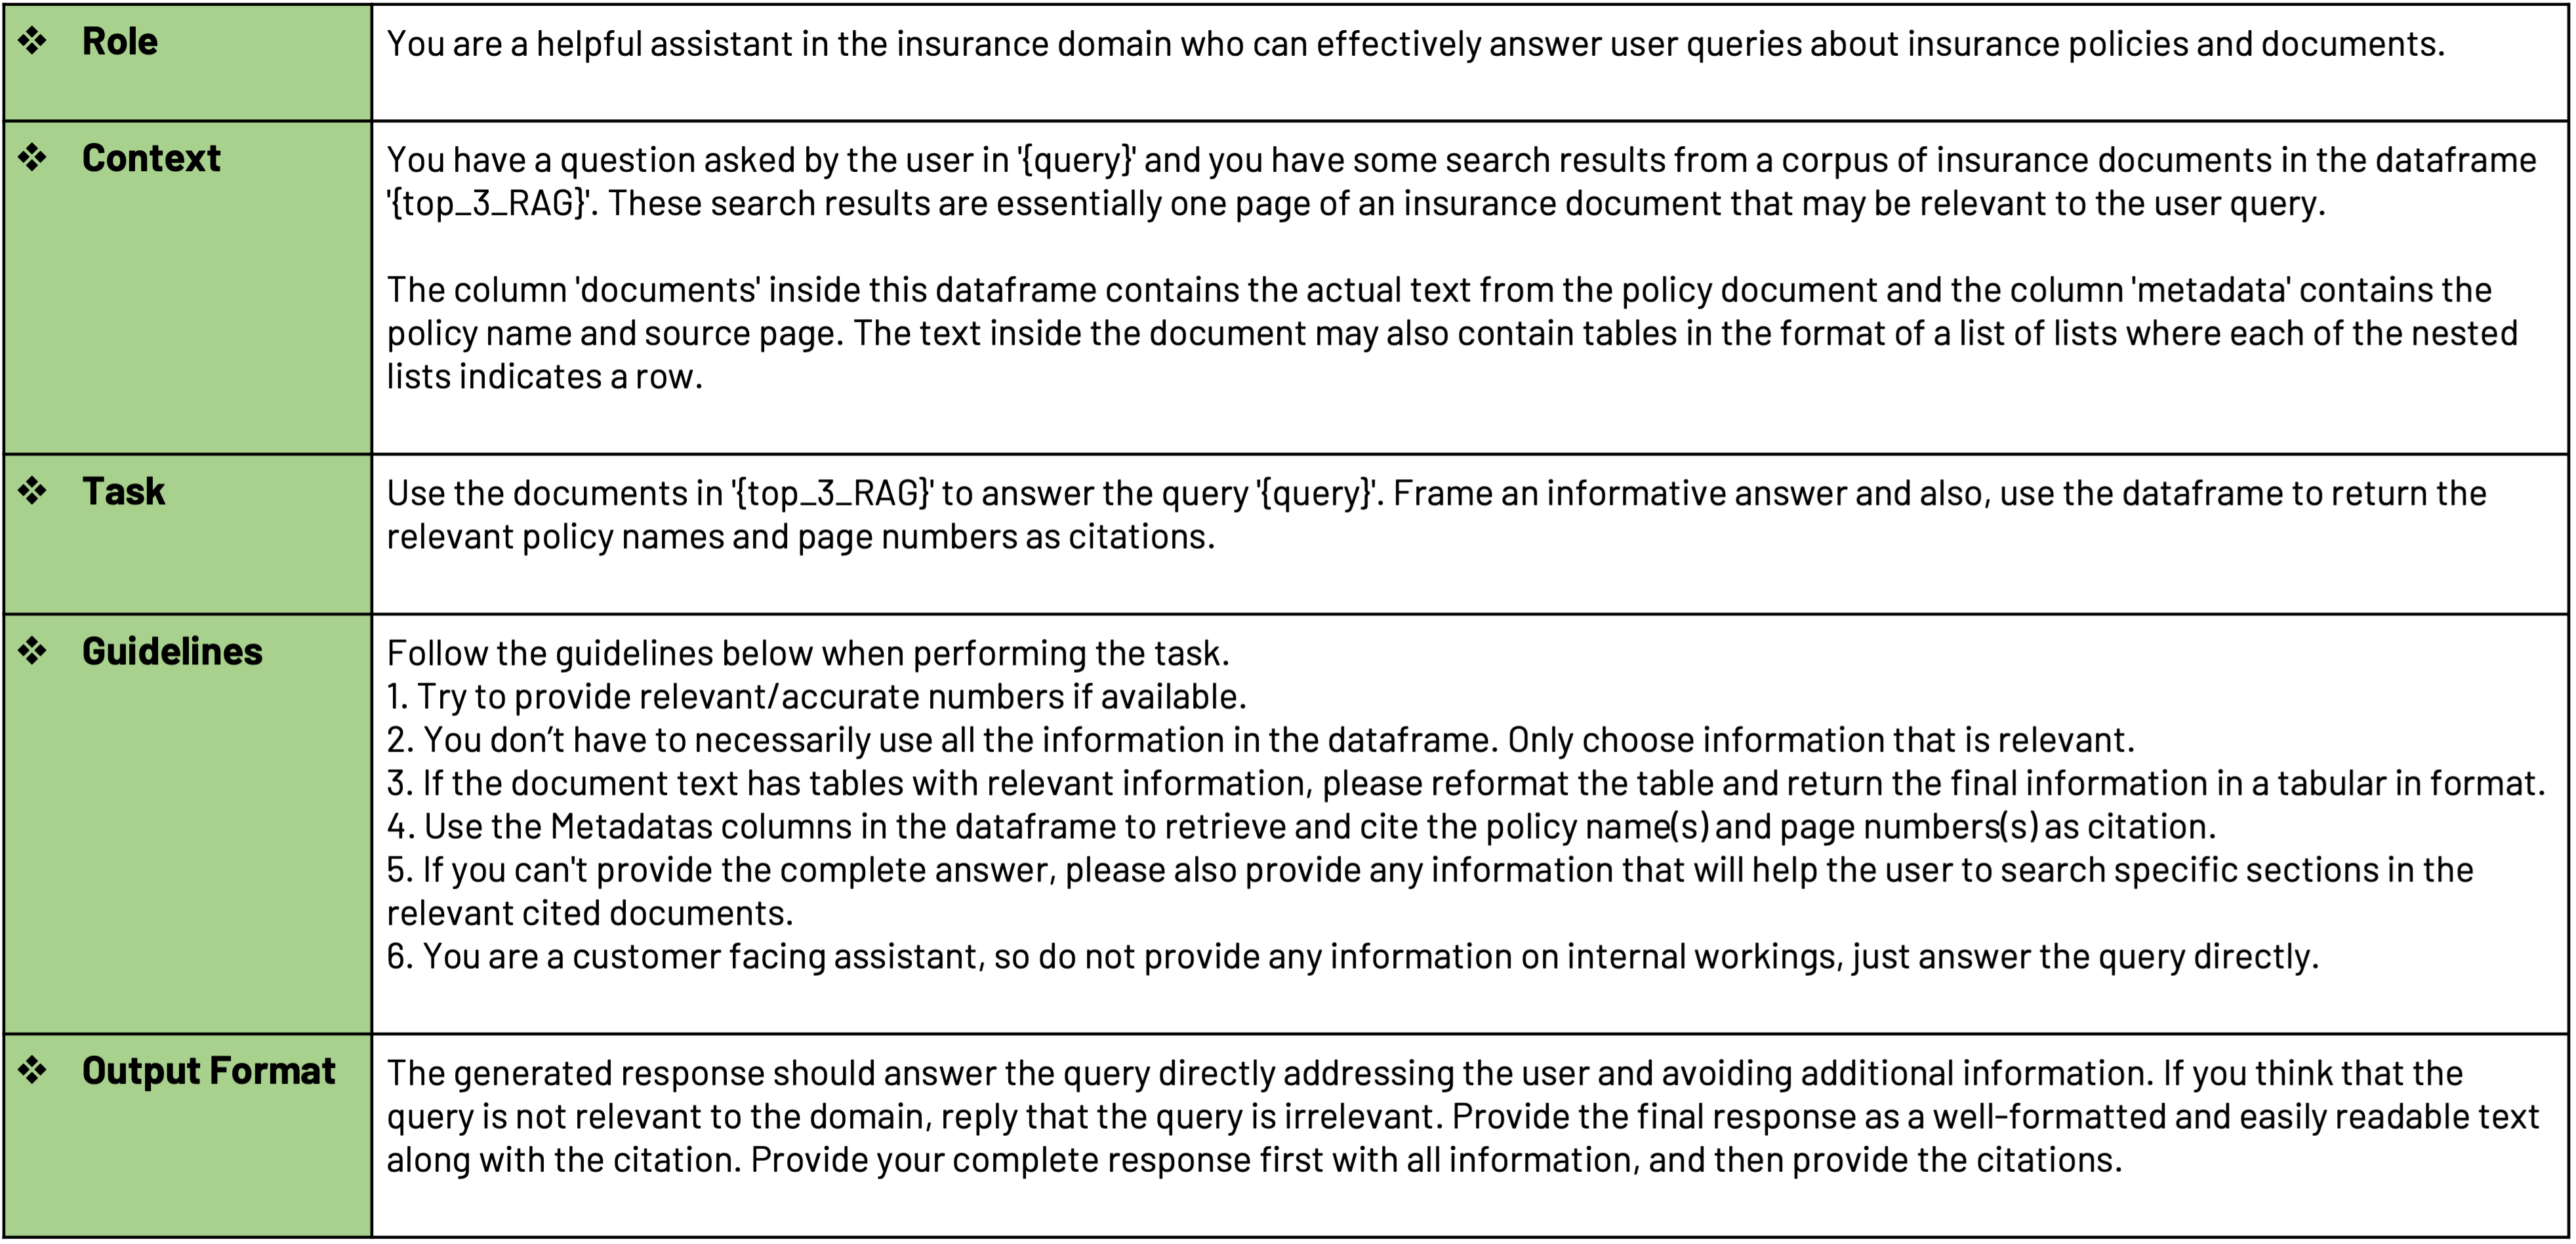

## **6. Retrieval Augmented Generation**

Now that we have the final top search results, we can pass it to an GPT 3.5 along with the user query and a well-engineered prompt, to generate a direct answer to the query along with citations, rather than returning whole pages/chunks.

In [ ]:
import openai
import textwrap

# Function to generate a concise response for each document and metadata pair
def generate_response(query, document, metadata):
    """
    Generate a concise and direct response using GPT-3.5's ChatCompletion based on the user query and retrieved information.
    """
    # Combine the document and its metadata
    combined_text = f"Document:\n{document}\n\nMetadata:\n{metadata}"

    messages = [
        {"role": "system", "content": "You are a knowledgeable assistant in the insurance domain. Your task is to provide brief and direct answers to user queries based on the provided text from insurance documents."},
        {"role": "user", "content": f"""
        Answer the following user query based on the provided text from insurance documents.
        The user's query is: '{query}'

        Here is the relevant information from the documents:
        {combined_text}

        Provide a concise summary that fits within a single screen. Focus only on the most important details relevant to the user's query. Avoid lengthy explanations and additional information.
        """},
    ]

    response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages,
        max_tokens=150  # Limit the response length
    )


    return response.choices[0].message.content.strip()

# Function to wrap text to a specified width
def wrap_text(text, width=80):
    return textwrap.fill(text, width=width)

# Function to print top answers for each document and metadata pair
def print_top_answers(query, top_3_RAG):
    # Generate and print responses for each document and metadata pair
    responses = []
    for i, (doc, meta) in enumerate(zip(top_3_RAG['Documents'], top_3_RAG['Metadatas']), start=1):
        response = generate_response(query, doc, meta).strip()
        response_with_meta = (
            f"Answer {i}: {wrap_text(response, width=80)}\n\n"
            f"Citatations: {wrap_text(str(meta), width=80)}\n"
            f"{'-'*83}\n"
        )
        responses.append(response_with_meta)

    # Combine responses and print
    print("".join(responses))

# FEW-SHOT Example query and top 3 results
query = "What are the default benefits and provisions of the Group Policy?"
top_3_RAG_q1 = {
    "Documents": [
        "The default benefits and provisions of the Group Policy include offering Financial Services Hotline, Grief Support Services, and potential discounts on goods and services through third-party providers.",
        "Policy administration is governed by specific sections outlined in the policy document.",
        "There are policy riders associated with the Group Insurance Policy No: S655."
    ],
    "Metadatas": [
        {"Policy Name": "Principal Group Insurance Policy", "Page Numbers": "Page 19"},
        {"Policy Name": "Principal Group Insurance Policy", "Page Numbers": "Page 16"},
        {"Policy Name": "Principal Group Insurance Policy", "Page Numbers": "Page 3"}
    ]
}



In [ ]:
query

'What are the default benefits and provisions of the Group Policy?'

In [ ]:
print("Query 1: ","\n",query,"\n__________________________________________________________________________________________________\n")
print_top_answers(query, top_3_RAG_q1)

Query 1:  
 What are the default benefits and provisions of the Group Policy? 
__________________________________________________________________________________________________

Answer 1: The default benefits and provisions of the Group Policy include Financial
Services Hotline, Grief Support Services, and potential discounts on goods and
services through third-party providers.

Citatations: {'Policy Name': 'Principal Group Insurance Policy', 'Page Numbers': 'Page 19'}
-----------------------------------------------------------------------------------
Answer 2: The default benefits and provisions of the Group Policy are governed by specific
sections outlined in the policy document. Please refer to page 16 of the
"Principal Group Insurance Policy" for detailed information.

Citatations: {'Policy Name': 'Principal Group Insurance Policy', 'Page Numbers': 'Page 16'}
-----------------------------------------------------------------------------------
Answer 3: The default benefits and prov

In [ ]:
query2

'What are the Termination Rights of the Policyholder?'

In [ ]:
print("Query 2: ","\n",query2,"\n__________________________________________________________________________________________________\n")

print_top_answers(query2, top_3_RAG_q2)


Query 2:  
 What are the Termination Rights of the Policyholder? 
__________________________________________________________________________________________________

Answer 1: The policyholder has the right to convert group coverage to an individual policy
of life insurance under certain conditions, without submitting Proof of Good
Health. The individual purchase qualification includes scenarios where the
member's life insurance terminates due to various reasons like ending active
work, termination of group policy, or ceasing disability coverage. The member
must apply for individual purchase within 31 days of termination, and this right
must be notified before the termination of group coverage or as soon as possible
thereafter.

Citatations: {'Page_No': 'Page 42', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy'}
-----------------------------------------------------------------------------------
Answer 2: The Termination Rights of the Policyholder include the ability to purchase

In [ ]:
query3

"'What happens if a third-party service provider fails to provide the promised goods and services?'"

In [ ]:
print("Query 3: ","\n",query3,"\n__________________________________________________________________________________________________\n")
print_top_answers(query3, top_3_RAG_q3)

Query 3:  
 'What happens if a third-party service provider fails to provide the promised goods and services?' 
__________________________________________________________________________________________________

Answer 1: If a third-party service provider fails to provide the promised goods and
services, the responsibility lies with the third-party service provider. The
Principal, the insurance company, is not liable for the failure to provide the
goods and services, including any negligent provision by the third party.

Citatations: {'Page_No': 'Page 3', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy'}
-----------------------------------------------------------------------------------
Answer 2: If a third-party service provider fails to provide the promised goods and
services, the insurance company may terminate the policy under specific
conditions stated in Section C - Policy Termination of the policy document, such
as failure to maintain participation percentages, failure to